# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.impute import SimpleImputer

#Model
from sklearn.ensemble import RandomForestClassifier

#GridSearch - Hypertunning
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve

from yellowbrick.model_selection import LearningCurve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from yellowbrick.model_selection import FeatureImportances

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
game_stats = pd.read_csv('../../src/data/game_stats.csv')

# Function

In [8]:
# Filling NaN values with 0, because its a our webscrapping source, when these values do not occur,  the site does not show the output so it can be adopted as a zero value.
def func(x):
    """
    Applying a function that change values of a Draw Match to 0, when Home team won to 1 and Away team won to -1.
    """
    if x == 'Draw':
        return 0
    elif x == 'Home':
        return 1
    else:
        return -1

def apply_func(dataframe, column_list):
    for column in column_list:
        dataframe[column] = dataframe[column].apply(func)

# Random Forest Model

In [9]:
model = RandomForestClassifier(n_jobs=-1)

## Why Random Forest?

The random forest is a model made up of many decision trees. The technical details of a decision tree are in how the questions about the data are formed. A decision tree is built by determining the questions (called splits of nodes) that, when answered, lead to the greatest reduction in Gini Impurity. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

* Random sampling of training data points when building trees
* Random subsets of features considered when splitting nodes

In other words, in building a random forest, at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors. This may sound crazy, but it has a clever rationale. 


## HyperTunning Parameters - GridSearch

Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions. This is significant as the performance of the entire model is based on the hyper parameter values specified.

In [10]:
list_result = ['final_result', '1half_result']

In [11]:
apply_func(game_stats, list_result)

In [12]:
game_stats = game_stats.fillna(0)

In [13]:
# Defining X and Y

X = game_stats.drop('url', axis=1)
X = X.loc[:, 'goals_home_1half':]
y = game_stats['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [14]:
# Random Forest Parameters to optimize:
                                                       # Parameters explained:
param_grid = {'n_estimators': [1, 2, 3, 4],         # The number of trees in the forest.
              'criterion': ['gini', 'entropy'],        # The function to measure the quality of a split.
              'max_features': ['auto', 'sqrt'],        # The number of features to consider when looking for the best split
              'max_depth': [1, 2, 3, 4, 5, None], # The maximum depth of the tree.
              'min_samples_split': [5, 10, 20],         # The minimum number of samples required to split an internal node
              'min_samples_leaf': [5, 10, 20],           # The minimum number of samples required to be at a leaf node.
              'bootstrap': [True, False]}              # Whether bootstrap samples are used when building trees.

In [15]:
gsearch = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [16]:
random_model = gsearch.fit(X_train, y_train)

In [17]:
# Best params by the best score

print(random_model.best_params_, random_model.best_score_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 3} 0.6216287678476996


In [18]:
random_model.score(X_test, y_test)

0.44680851063829785

# Pipeline

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling. As the name suggests, pipeline class allows sticking multiple processes into a single scikit-learn estimator.

In [19]:
game_stats = pd.read_csv('../../src/data/game_stats.csv')

## Data-Prep

Here we will synthesize the data preparation processes, so that you are ready to use the ideal model. The process of transforming categorical features into numbers, standardization of data and adding value to missing numbers.

In [20]:
scaler = StandardScaler()

In [21]:
num_columns = list(X_train.columns)

In [22]:
list_result = ['final_result', '1half_result']

In [23]:
numerical_pipeline = Pipeline(steps=[('result', apply_func(game_stats, list_result)),
                                    ('missing', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('standardize', scaler)])

In [24]:
dataprep = ColumnTransformer(transformers=[('numerical_transform', numerical_pipeline, num_columns)])

## Modeling

Using the parameters obtained through GridSearch, we apply the model to the pipeline process and train them.

In [25]:
#model = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_depth = 3,
                               #max_features = 'sqrt', min_samples_leaf = 20, 
                               #min_samples_split = 20, n_estimators = 5, n_jobs=-1)

In [45]:
model = RandomForestClassifier(bootstrap = False, criterion = 'gini', max_depth = 5,
                               max_features = 'sqrt', min_samples_leaf = 20, 
                               min_samples_split = 10, n_estimators = 2, random_state=42,n_jobs=-1)

In [27]:
pipeline = Pipeline(steps=[('dataprep', dataprep),
                           ('model', model)])

In [28]:
# Defining X and Y

X = game_stats.drop('url', axis=1)
X = X.loc[:, 'goals_home_1half':]
y = game_stats['final_result']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('dataprep',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  Pipeline(steps=[('result',
                                                                   None),
                                                                  ('missing',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['goals_home_1half',
                                                   'goals_away_1half',
                                                   '1half_result',
                                                   'ball_possessionhome',
                 

In [31]:
roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

0.7536340261830458

In [32]:
precision_score(y_test, pipeline.predict(X_test), average='weighted')

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5528368794326242

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


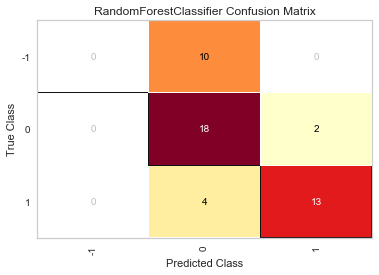

In [33]:
cm = ConfusionMatrix(pipeline, classes=pipeline.classes_)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


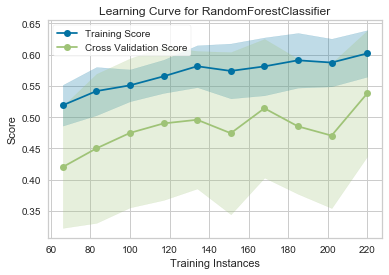

In [34]:
cv = StratifiedKFold(n_splits=20)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(
    pipeline, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


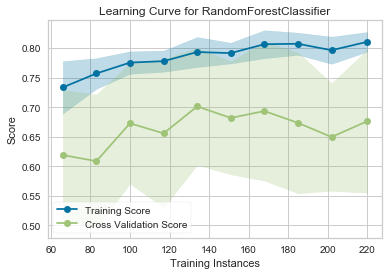

In [35]:
cv = StratifiedKFold(n_splits=20)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(
    pipeline, cv=cv, scoring='roc_auc_ovr', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [36]:
results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='accuracy')
(np.mean(results), np.std(results))

(0.58, 0.13391539617733778)

In [37]:
results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.6623561507936508, 0.14356051630948752)

In [38]:
results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='f1_weighted')
(np.mean(results), np.std(results))

(0.47918678852012186, 0.09837460905319255)

# PICKLE

In [42]:
import joblib

In [43]:
joblib.dump(pipeline, 'stats-model.pkl')

['stats-model.pkl']

C:\Users\Zaparolli\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


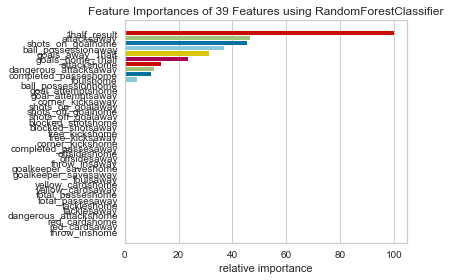

In [44]:
viz = FeatureImportances(model)
viz.fit(X_train, y_train)
viz.show()

In [65]:
import shap
shap.initjs()

In [66]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [67]:
shap_values = explainer.shap_values(X_test)

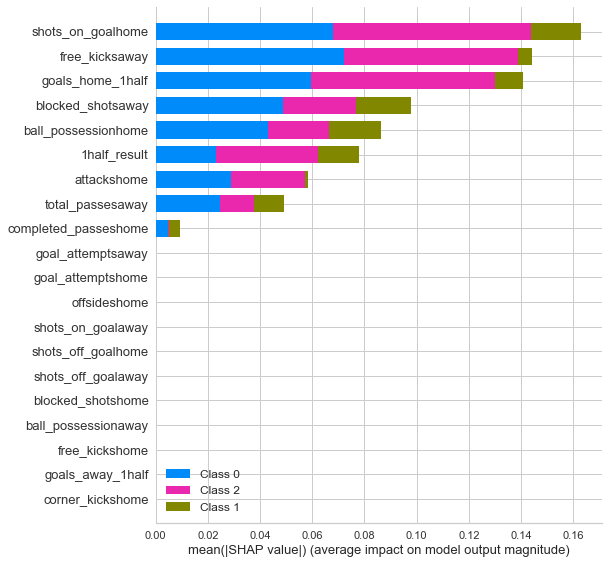

In [68]:
shap.summary_plot(shap_values, X_test)

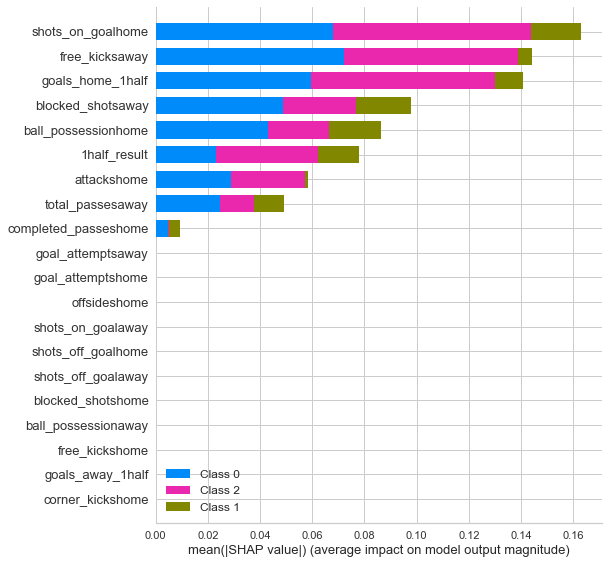

In [69]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [71]:
shap.dependence_plot('temperature', shap_values, X_test, interaction_index=None)

AttributeError: 'list' object has no attribute 'shape'

In [92]:
expected_value = explainer.expected_value

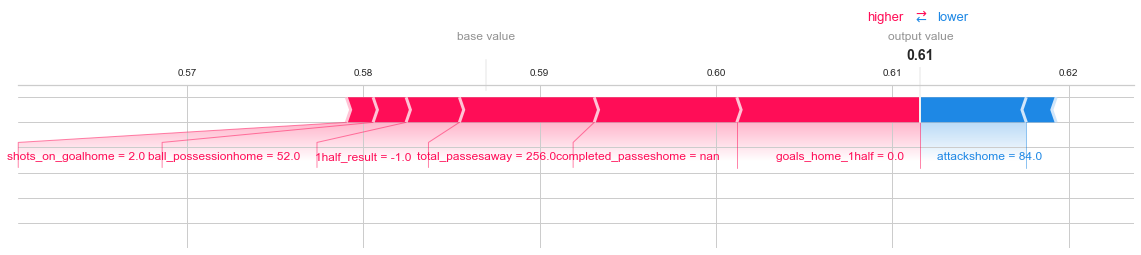

In [81]:
shap.force_plot(expected_value[0], shap_values[0], X.iloc[0, :], link='logit', show=False, matplotlib=True)

In [58]:
expected_value

array([0.35135135, 0.22702703, 0.42162162])

In [72]:
explainer = shap.KernelExplainer(lambda x : pipeline.named_steps.model.predict_proba(x)[:,1], data=pipeline.named_steps.dataprep.transform(X_train))

Using 185 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [73]:
single_row = X_train.sample(random_state=3)

In [74]:
base_value = explainer.expected_value

shap_values = explainer.shap_values(pipeline.named_steps.dataprep.transform(single_row))

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


In [77]:

display_features = pd.DataFrame(pipeline['dataprep'].transform(single_row), columns=num_columns)

In [79]:
shap.force_plot(base_value, shap_values, features=display_features, plot_cmap='BlRd', link='logit')